In [57]:
# imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import csv
from datetime import timedelta

In [52]:
# new file

newf = open("cleaned_sleep_analysis.csv", 'w')

with open("../data/HKCategoryTypeIdentifierSleepAnalysis.csv", 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        newf.write(row[2] + ", " + row[3] + ", " + row[5])
        newf.write("\n")

newf.close()

In [53]:
# clean

temp = list()
newf = open("cleaned_sleep_analysis.csv", 'r')
reader = csv.reader(newf)

for row in reader:
    temp.append([
        row[0].lstrip(), 
        row[1].lstrip(), 
        row[2].lstrip().removeprefix("HKCategoryValueSleepAnalysis"),
        "1" if "Asleep" in row[2].lstrip().removeprefix("HKCategoryValueSleepAnalysis") else "0",
    ])

newf.close()
newf = open("cleaned_sleep_analysis.csv", 'w')
for row in temp:
    newf.write(",".join(row))
    newf.write("\n")

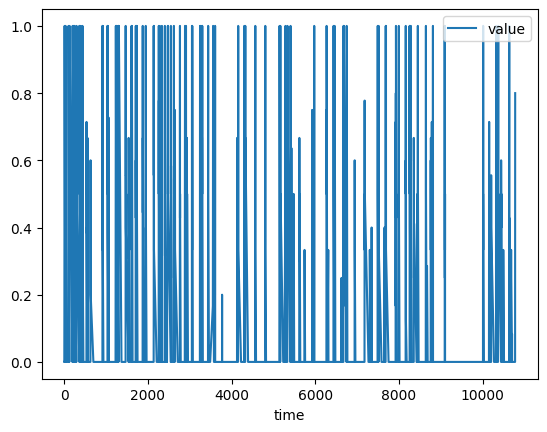

In [60]:
# plot

# couldn't import this from file bc jupyter is stupid
def aggregate_data_by_interval(file, interval):
    # Convert 'start' to datetime
    df = pd.read_csv(file)
    df['start'] = pd.to_datetime(df['start'], errors='coerce')

    # Drop rows where 'start' could not be converted to datetime
    df = df.dropna(subset=['start'])
    
    # Sort by 'start' time to ensure chronological order
    df = df.sort_values(by='start')

    # Set the start time as the base reference
    start_time = df['start'].min()

    # Create a new time index based on the given interval
    if interval == 'minutes':
        time_delta = timedelta(minutes=1)
    elif interval == 'hours':
        time_delta = timedelta(hours=1)
    elif interval == 'days':
        time_delta = timedelta(days=1)
    else:
        raise ValueError("Interval must be 'minutes', 'hours', or 'days'")

    # Create an empty list to store results
    results = []
    time_counter = 0
    current_time = start_time

    while current_time <= df['start'].max():
        # Filter the data for the current interval
        interval_data = df[(df['start'] >= current_time) & (df['start'] < current_time + time_delta)]

        if not interval_data.empty:
            # Calculate the mean of 'value' for the interval
            mean_value = interval_data['value'].mean()

            # Add the aggregated result to the results list
            results.append({
                # 'source': interval_data['source'].iloc[0],  # Take the source from the first row
                'time': time_counter,
                'value': mean_value,
                # 'unit': interval_data['unit'].iloc[0],  # Take the unit from the first row
            })

        # Move to the next interval
        current_time += time_delta
        time_counter += 1

    # Convert results into a DataFrame
    result_df = pd.DataFrame(results)
    return result_df

aggregated_df = aggregate_data_by_interval('cleaned_sleep_analysis.csv', 'hours')
aggregated_df.plot(kind='line', x='time', y='value')

aggregated_df.to_csv('maybe_cleaned_sleep_analysis.csv', index=False)

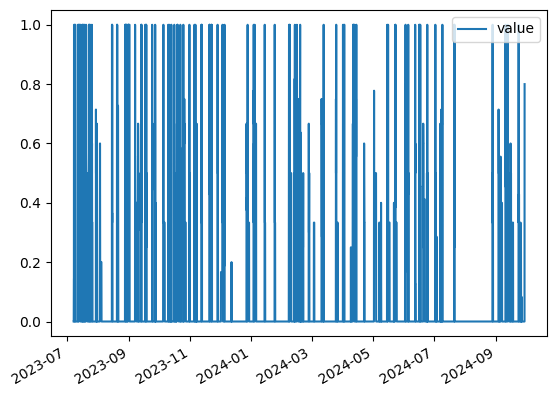

In [141]:
# more clean

df = pd.read_csv("maybe_cleaned_sleep_analysis.csv")
df['time'] = pd.to_timedelta(df['time']*3600*10**9, errors='coerce') + pd.to_datetime('2023-07-07 23:30:52 -0400')

common_time = pd.date_range(start=df['time'].iloc[0], end=df['time'].iloc[-1], freq='h')
df = df.set_index('time')
interpolated = df.reindex(common_time, method='nearest').interpolate()

interpolated.plot(kind='line', y='value')
interpolated.to_csv('interpolated_sleep_analysis.csv', index=True)

In [122]:
# filter 

